Define the problem with PySCF and initialize the qubit mapper and ansatz with Qiskit.

In [1]:
from __future__ import annotations

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto-3g")
problem = driver.run()

mapper = JordanWignerMapper()

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)


/home/hao/.pyenv/versions/3.11.7/envs/oscar/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/home/hao/.pyenv/versions/3.11.7/envs/oscar/lib/python3.11/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


Define VQE and the corresponding OSCAR executor.

In [2]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_aer.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from oscar import QiskitExecutor

vqe = VQE(
    Estimator(run_options={"shots": None}, approximation = True),
    ansatz,
    SLSQP(),
)
solver = GroundStateEigensolver(mapper, vqe)
operator, _ = solver.get_qubit_operators(problem)
executor = QiskitExecutor(vqe, operator)


Define the landscape grid and run grid points. This may take a while.

In [3]:
from math import pi
from oscar import Landscape, plot_2d_landscape

n_params = ansatz.num_parameters
resolution = [25] * n_params
bounds = (-pi / 2, pi / 2)

landscape = Landscape(resolution, bounds)
_ = landscape.run_all(executor)


Optionally, run a normal optimiztion so we can plot the optimization trace over the landscape.

In [5]:
from oscar import NLoptOptimizer, QiskitOptimizer

trace, original_result = NLoptOptimizer("LN_COBYLA", xtol_abs=1e-11).run(
    executor, initial_point=[0] * n_params, bounds=[bounds] * n_params
)
trace.print_result()


Total evaluation time: 0.29975152015686035
Optimal parameters reported: [ 3.07932558e-08 -3.35756886e-08 -1.11768489e-01]
Optimal value reported: -1.8572750302023755
Number of evaluations: 133


To get 2D landscapes suitable for visualization, we get a slice of the high-dimensional landscape to plot. In the below example, we slice the 3D landscape by fixing the first, second, and the third parameter respectively to 0 (corresponding to index 12 in our grid definition). Note the 3D trace is projected on to the slice by specifying `trace_plot_params`.

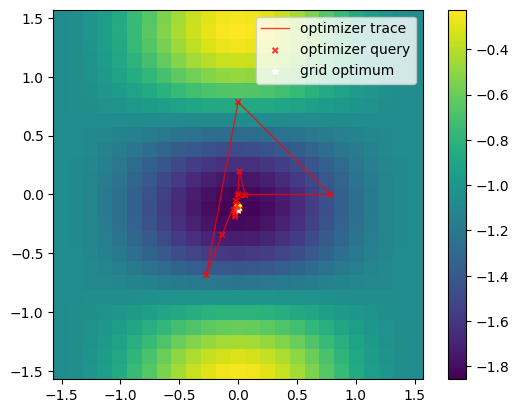

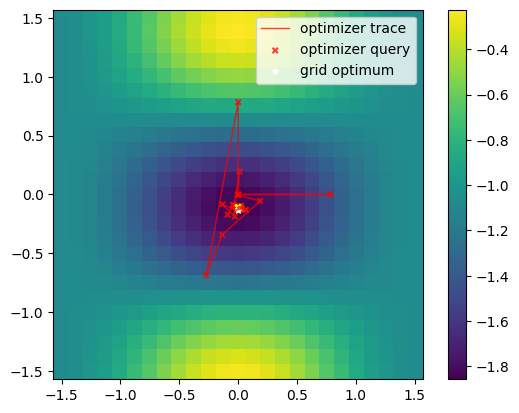

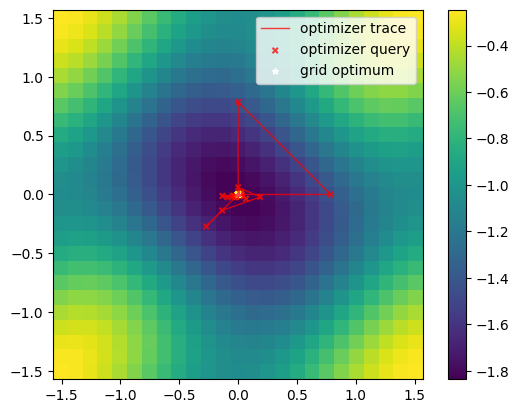

In [7]:
plot_2d_landscape(landscape[12], trace.project_to(1, 2))
plot_2d_landscape(landscape[:, 12], trace.project_to(0, 2))
_ = plot_2d_landscape(landscape[:, :, 12], trace.project_to(0, 1))


Or we can fix one of the parameters to a desired value (optimizer-reported optimal parameter values in the below example) in the VQE definition to avoid computing the huge 3D landscape. We can also do a higher resolution this way.

/home/hao/.pyenv/versions/3.11.7/envs/oscar/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


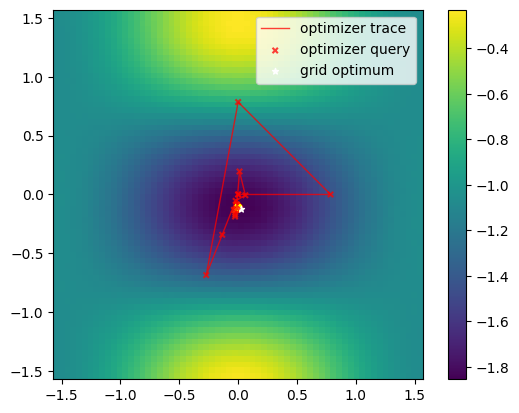

/home/hao/.pyenv/versions/3.11.7/envs/oscar/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


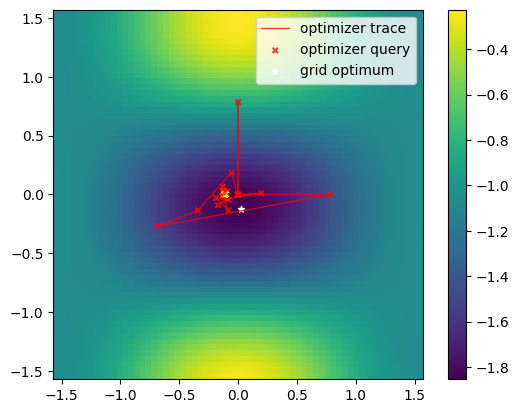

/home/hao/.pyenv/versions/3.11.7/envs/oscar/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


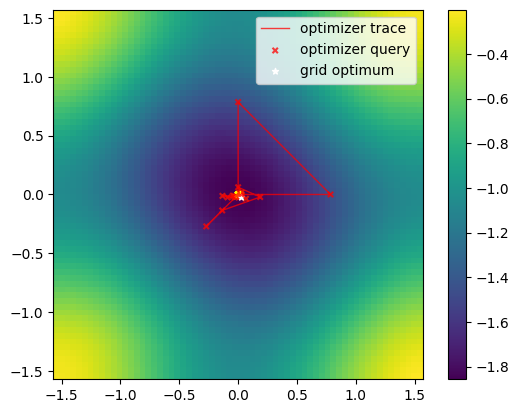

In [9]:
for i in range(len(ansatz.parameters)):
    vqe = VQE(
        Estimator(run_options={"shots": None}, approximation = True),
        ansatz.assign_parameters({ansatz.parameters[i]: trace.optimal_params[i]}), # fix one parameter
        SLSQP(),
    )
    solver = GroundStateEigensolver(mapper, vqe)
    operator, _ = solver.get_qubit_operators(problem)
    executor = QiskitExecutor(vqe, operator)
    landscape_slice = Landscape([64, 64], bounds)
    landscape_slice.sample_and_run(executor, sampling_fraction = 1 / 16)
    landscape_slice.reconstruct()
    plot_2d_landscape(landscape_slice, trace.project_to((i + 1) % 3, (i + 2) % 3))
